In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.utils.data import TensorDataset, DataLoader,Dataset
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import torch.nn as nn


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()
print(device)
print(torch.cuda.get_device_name(0))
print(torch.cuda.memory_summary())

cuda
NVIDIA GeForce RTX 4070 Laptop GPU
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool 

In [3]:
dataset = "data/filtered_001.csv"
df = pd.read_csv(dataset)
df

,Genotype,SNP100062891chr7A,SNP100062904chr7A,SNP100062911chr7A,SNP100062984chr7A,SNP100062988chr7A,SNP100063041chr7A,SNP100063122chr7A,SNP100063259chr7A,SNP100063376chr7A,...,SNP9993508chrUn,SNP9993611chrUn,SNP9993771chrUn,SNP9993777chrUn,SNP9993786chrUn,SNP9993822chrUn,SNP9993925chrUn,SNP9993929chrUn,SNP9993942chrUn,Phenotype
0,F001,2,2,2,2,2,2,2,2,2,...,0,0,0,0,0,0,0,0,0,1.393994
1,F003,0,0,0,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,3.508284
2,F004,0,0,0,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,0.839029
3,F005,0,0,0,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,4.769238
4,F006,2,2,2,2,2,2,2,2,2,...,0,0,0,0,0,0,0,0,0,1.681682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,M011,0,0,0,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,3.927772
129,M012,0,0,0,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,4.071781
130,M013,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2.965584
131,M014,0,0,0,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,3.412571


In [4]:
X = df.drop(columns=["Genotype","Phenotype"])
y = df["Phenotype"]

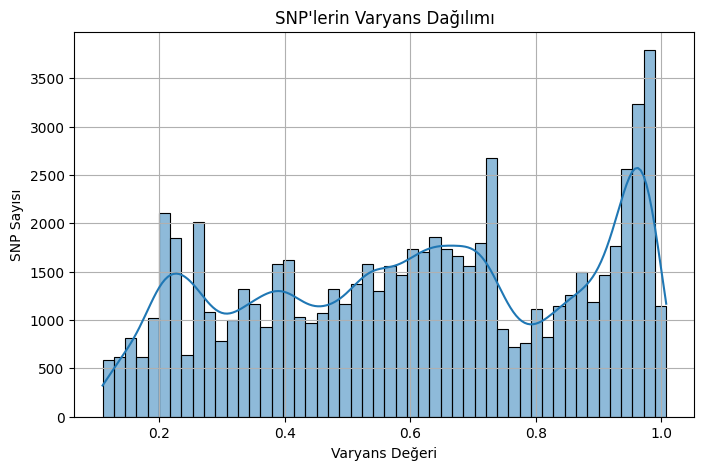

25. yüzdelik dilim (Q1): 0.38812941444520394
Medyan (Q2): 0.6203007518796991
75. yüzdelik dilim (Q3): 0.848257006151743
Önerilen Threshold Değeri: 0.38812941444520394


In [5]:
variances = X.var(axis=0)

plt.figure(figsize=(8, 5))
sns.histplot(variances, bins=50, kde=True)
plt.xlabel("Varyans Değeri")
plt.ylabel("SNP Sayısı")
plt.title("SNP'lerin Varyans Dağılımı")
plt.grid()
plt.show()


q25 = variances.quantile(0.25)  # 25. yüzdelik dilim
median = variances.median()      # Medyan (50. yüzdelik dilim)
q75 = variances.quantile(0.75)  # 75. yüzdelik dilim

print(f"25. yüzdelik dilim (Q1): {q25}")
print(f"Medyan (Q2): {median}")
print(f"75. yüzdelik dilim (Q3): {q75}")

optimal_threshold = q25  
print(f"Önerilen Threshold Değeri: {optimal_threshold}")

In [6]:
var_thresh = VarianceThreshold(threshold=optimal_threshold) 
X_var_filtered = pd.DataFrame(var_thresh.fit_transform(X), columns=X.columns[var_thresh.get_support()])
print(f"1. Varyans filtresinden sonra kalan SNP sayısı: {X_var_filtered.shape[1]}")
n_features = X_var_filtered.shape[1]

1. Varyans filtresinden sonra kalan SNP sayısı: 52848


In [7]:
X_var_filtered = np.array(X_var_filtered)
y = np.array(y)

In [8]:
# Train-Test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_var_filtered, y, test_size=0.2)

# Further split train into train/val (80/20 split of the train set)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2)

In [9]:
class SNPPhenotypeDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float().unsqueeze(1)
        self.y = torch.from_numpy(y).float().unsqueeze(-1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = SNPPhenotypeDataset(X_train, y_train)
val_dataset   = SNPPhenotypeDataset(X_val, y_val)
test_dataset  = SNPPhenotypeDataset(X_test, y_test)

batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [10]:
class theNet(nn.Module):
    def __init__(self, input_length):
        super(theNet, self).__init__()  # Remove the 'self' parameter here
        self.input = nn.Linear(input_length, 512)
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 1)
        self.dropout = nn.Dropout(p=0.3)
        
    def forward(self, x):
        x = F.relu(self.input(x))
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        return self.output(x)

input_length = X_train.shape[1]
model = theNet(input_length)
model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.001, weight_decay=1e-5)  # Use model.parameters() instead of theNet.parameters()
patience = 10
best_val_loss = float("inf")
epochs_no_improve = 0
max_epochs = 200

In [11]:
train_losses = []
val_losses   = []

for epoch in range(max_epochs):
    model.train()
    running_train_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * batch_X.size(0)

    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            running_val_loss += loss.item() * batch_X.size(0)

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    print(f"Epoch [{epoch+1}/{max_epochs}] | "
          f"Train Loss: {epoch_train_loss:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f}")

    # Early Stopping Check
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_model_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print("Early stopping triggered!")
        break

c:\Users\LEGION\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([8, 1])) that is different to the input size (torch.Size([8, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\LEGION\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\LEGION\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([6, 1])) that is different to the input size (torch.Size([6, 1, 1])). This will likel

Epoch [1/200] | Train Loss: 5.6936 | Val Loss: 2.6999
Epoch [2/200] | Train Loss: 5.9958 | Val Loss: 2.8134
Epoch [3/200] | Train Loss: 3.9489 | Val Loss: 4.8577
Epoch [4/200] | Train Loss: 2.9730 | Val Loss: 5.9267
Epoch [5/200] | Train Loss: 3.0716 | Val Loss: 3.1324
Epoch [6/200] | Train Loss: 3.1072 | Val Loss: 2.9159
Epoch [7/200] | Train Loss: 2.9538 | Val Loss: 5.0910
Epoch [8/200] | Train Loss: 3.1933 | Val Loss: 3.1230
Epoch [9/200] | Train Loss: 2.4132 | Val Loss: 2.4430
Epoch [10/200] | Train Loss: 2.6060 | Val Loss: 4.5498
Epoch [11/200] | Train Loss: 2.7588 | Val Loss: 4.0274
Epoch [12/200] | Train Loss: 2.5691 | Val Loss: 3.5125
Epoch [13/200] | Train Loss: 2.7761 | Val Loss: 1.7740
Epoch [14/200] | Train Loss: 2.4524 | Val Loss: 3.3602
Epoch [15/200] | Train Loss: 2.5269 | Val Loss: 3.6909
Epoch [16/200] | Train Loss: 2.7198 | Val Loss: 3.4047
Epoch [17/200] | Train Loss: 2.4235 | Val Loss: 2.5244
Epoch [18/200] | Train Loss: 2.7639 | Val Loss: 2.5769
Epoch [19/200] | Tr

In [12]:
model.load_state_dict(best_model_state)

model.eval()

all_preds = []
all_targets = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        outputs = model(batch_X)
        all_preds.append(outputs.cpu().numpy())
        all_targets.append(batch_y.numpy())

y_pred = np.concatenate(all_preds).reshape(-1)
y_true = np.concatenate(all_targets).reshape(-1)

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2  = r2_score(y_true, y_pred)

print("\n=== Final Evaluation on Test Set ===")
print(f"MSE:  {mse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R^2:  {r2:.4f}")


=== Final Evaluation on Test Set ===
MSE:  3.0156
MAE:  1.4687
R^2:  -0.9508


In [13]:
import pandas as pd

dataset_name = dataset.split("/")[-1:][0]
variance_threshold = optimal_threshold

model_stats = {
    "dataset": [dataset_name],
    "dataset size" : df.shape[1],
    "variance_threshold": [variance_threshold],
    "dataset size after vt" : X_var_filtered.shape[1],
    "MSE": [round(mse,3)],
    "MAE": [round(mae,3)],
    "R2": [round(r2,3)]
}

model_stats_df = pd.DataFrame(model_stats)
model_stats_df.to_csv(f"{dataset_name}_stats_05_005.csv", index=False)

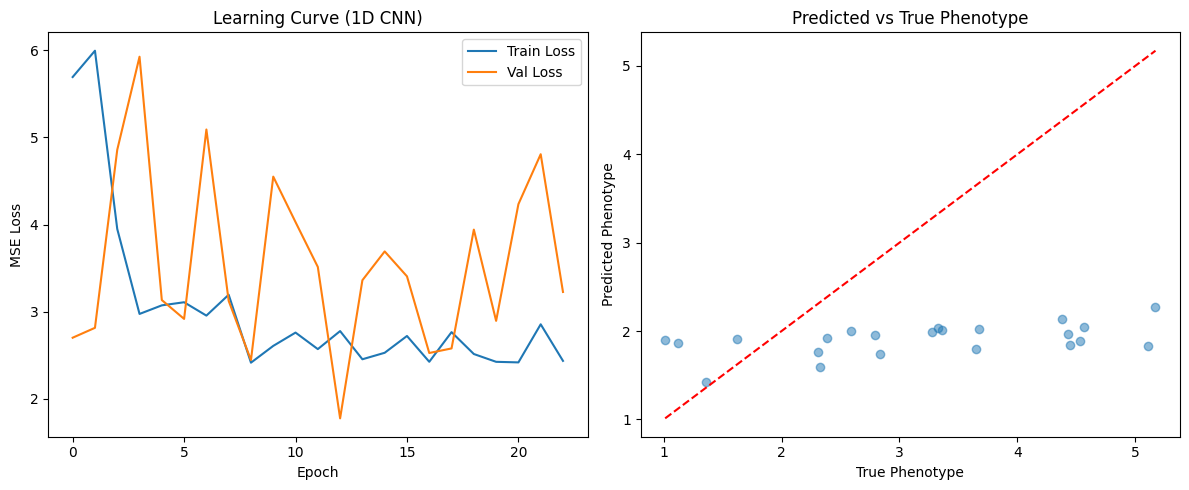

In [14]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Learning Curve (1D CNN)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()

# 8.2 Predicted vs. True
plt.subplot(1, 2, 2)
plt.scatter(y_true, y_pred, alpha=0.5)
min_val = min(min(y_true), min(y_pred))
max_val = max(max(y_true), max(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.title("Predicted vs True Phenotype")
plt.xlabel("True Phenotype")
plt.ylabel("Predicted Phenotype")

plt.tight_layout()
plt.show()

In [15]:
PATH = "MLP_models/best_MLP_v1.pth"
torch.save(model.state_dict(), PATH)

In [16]:
new_model = theNet(X_train.shape[1])
new_model.load_state_dict(torch.load(PATH, map_location=device))  
new_model = new_model.to(device) 
new_model.eval()

all_preds = []
all_targets = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        outputs = new_model(batch_X)
        all_preds.append(outputs.cpu().numpy())
        all_targets.append(batch_y.numpy())

y_pred = np.concatenate(all_preds).reshape(-1)
y_true = np.concatenate(all_targets).reshape(-1)

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2  = r2_score(y_true, y_pred)

print("\n=== Final Evaluation on Test Set ===")
print(f"MSE:  {mse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R^2:  {r2:.4f}")


=== Final Evaluation on Test Set ===
MSE:  3.0156
MAE:  1.4687
R^2:  -0.9508


C:\Users\LEGION\AppData\Local\Temp\ipykernel_3192\2975116222.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  new_model.load_state_dict(torch.load(PATH, map_location=devi

In [1]:
import pandas as pd
df = pd.read_csv("merged_data.csv")
df

,Breeding line,population,S1A_1158055,S1A_1238021,S1A_3452684,S1A_3469197,S1A_3793383,S1A_3978918,S1A_3978937,S1A_4159194,...,SUN_456673396,SUN_458088855,SUN_458680476,SUN_458680508,SUN_464606444,SUN_472782494,SUN_475092207,SUN_475092311,SUN_475287011,Yield
0,MASBC10038S_1001U,LND17_F5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,1,0,3.261735
1,MASBC10056S_3001,LND17_F5,0,0,0,0,0,0,0,0,...,1,0,2,2,0,1,0,2,2,3.706517
2,MASBC10056S_3003,LND17_F5,2,2,2,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,4.966733
3,MASBC10056S_3004U,LND17_F5,0,0,0,0,0,2,0,2,...,0,0,0,0,0,0,0,2,2,3.780648
4,MASBC10056S_3005,LND17_F5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,2,1,2.594562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1763,SWW14498DH840,PUL18_DH,0,0,0,2,2,2,2,2,...,2,2,0,0,2,2,0,0,2,9.118033
1764,SWW14498DH860,PUL18_DH,0,0,0,2,2,2,2,2,...,2,2,0,0,2,2,0,0,2,6.523471
1765,SWW14498DH870,PUL18_DH,0,0,0,2,2,2,2,2,...,2,2,0,0,2,2,0,0,2,7.042383
1766,SWW14498DH880,PUL18_DH,0,0,0,2,2,2,2,2,...,2,2,0,0,2,2,0,0,2,8.747381
